In [38]:
from glob import glob
import pandas as pd
import os
import seaborn as sns
import yaml
import matplotlib.pyplot as plt

os.chdir("/home/adri/Projects/phd/pipeline")

In [29]:
# Load all train dfs
train_df_list = []
for train_df_path in glob("models/*/models/*/train_scores.csv"):
    # get train id
    # train_id = train_df_path.split("/")[-2]
    # # get model name
    # model_name = train_df_path.split("/")[1]
    # # get the dataset name from the config file
    # config_path = f"models/{model_name}/configs/{train_id}.yaml"
    # with open(config_path, "r") as f:
    #     config = yaml.safe_load(f)
    # dataset_name = config["data"]["path"]
    # dataset_name = dataset_name.split("/")[-1].replace(".csv", "")

    train_id = train_df_path.split("/")[-2]


    train_df = pd.read_csv(train_df_path)
    train_df["train_id"] = train_id
    train_df_list.append(train_df)

In [51]:
train_df = pd.concat(train_df_list)

In [52]:
train_df.fillna("None", inplace=True)

In [58]:
# group by model and parameters
cols_to_group = train_df.drop(columns=['train_score', 'test_score']).columns

In [59]:
train_df.groupby([*cols_to_group.values]).test_score.value_counts().max()

5

In [60]:
grouped_train_df = train_df.groupby([*cols_to_group.values]).test_score.mean().sort_values(ascending=False).reset_index()

In [61]:
grouped_train_df

,C,class_weight,gamma,kernel,max_iter,model_name,data,pca,smote,train_id,...,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,random_state,splitter,penalty,solver,bootstrap,n_estimators,test_score
0,None,balanced,None,None,None,decission_tree,sod_frequencies,None,True,bd03bf25a8494d0,...,4.0,10.0,0.4,0.0,best,None,None,None,None,0.770667
1,None,balanced,None,None,None,decission_tree,sod_frequencies,None,False,b6d180053863cfc,...,4.0,5.0,0.0,0.0,best,None,None,None,None,0.762333
2,None,balanced,None,None,None,decission_tree,sod_frequencies,None,True,b7c1f6646a88c89,...,1.0,10.0,0.4,0.0,best,None,None,None,None,0.761667
3,None,balanced,None,None,None,decission_tree,no_sod_frequencies,20.0,True,24a46f12ce46706,...,2.0,2.0,0.3,42.0,random,None,None,None,None,0.761333
4,None,balanced,None,None,None,decission_tree,sod_frequencies,20.0,True,4df2f06a720c45c,...,2.0,2.0,0.4,42.0,best,None,None,None,None,0.747667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176275,None,balanced,None,None,None,decission_tree,no_sod_frequencies,30.0,False,ae9ea4f27047d51,...,2.0,2.0,0.3,0.0,random,None,None,None,None,0.238000
176276,None,balanced,None,None,None,decission_tree,no_sod_frequencies,20.0,False,5b2e72542e92e8c,...,4.0,5.0,0.2,42.0,random,None,None,None,None,0.235667
176277,None,balanced,None,None,None,decission_tree,no_sod_frequencies,None,False,137690dc1d6d433,...,4.0,5.0,0.2,0.0,random,None,None,None,None,0.230667
176278,None,balanced,None,None,None,decission_tree,sod_frequencies,None,False,68cf22b60339a97,...,2.0,5.0,0.3,42.0,best,None,None,None,None,0.227333


In [62]:
grouped_train_df.iloc[0]

C                                      None
class_weight                       balanced
gamma                                  None
kernel                                 None
max_iter                               None
model_name                   decission_tree
data                        sod_frequencies
pca                                    None
smote                                  True
train_id                    bd03bf25a8494d0
criterion                           entropy
max_depth                               5.0
max_features                           sqrt
min_samples_leaf                        4.0
min_samples_split                      10.0
min_weight_fraction_leaf                0.4
random_state                            0.0
splitter                               best
penalty                                None
solver                                 None
bootstrap                              None
n_estimators                           None
test_score                      

In [93]:
model

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, random_state=0)

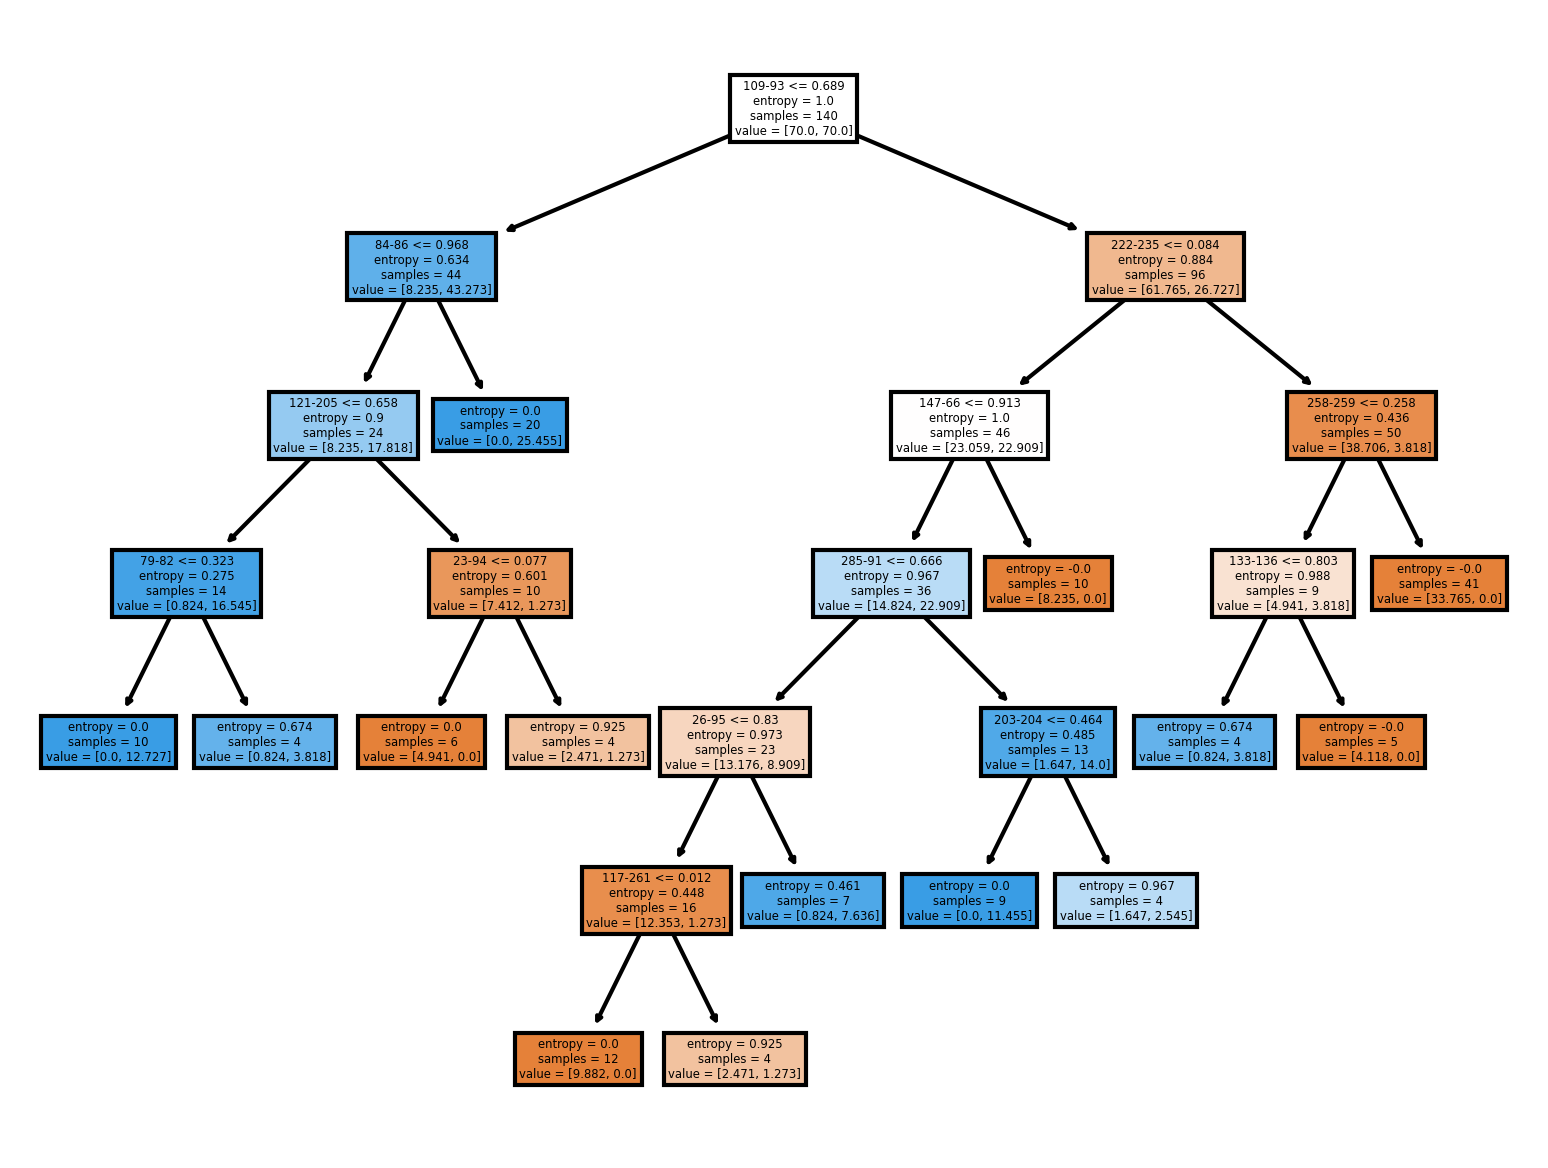

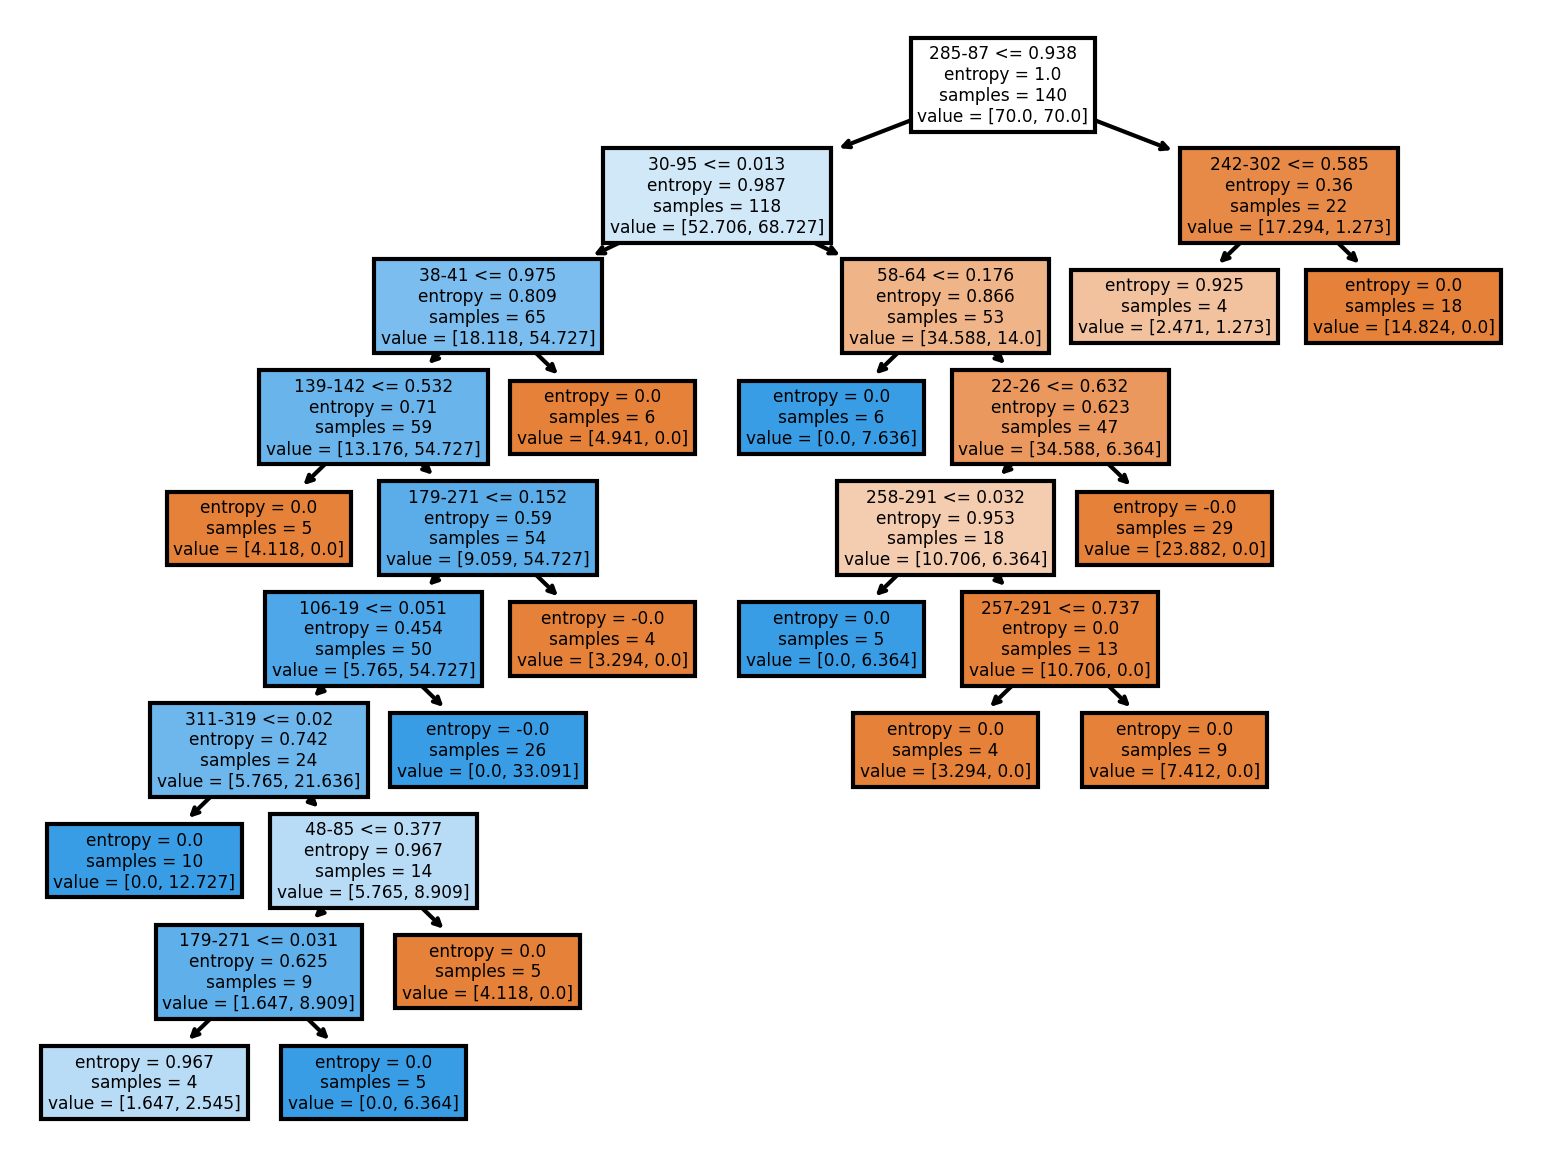

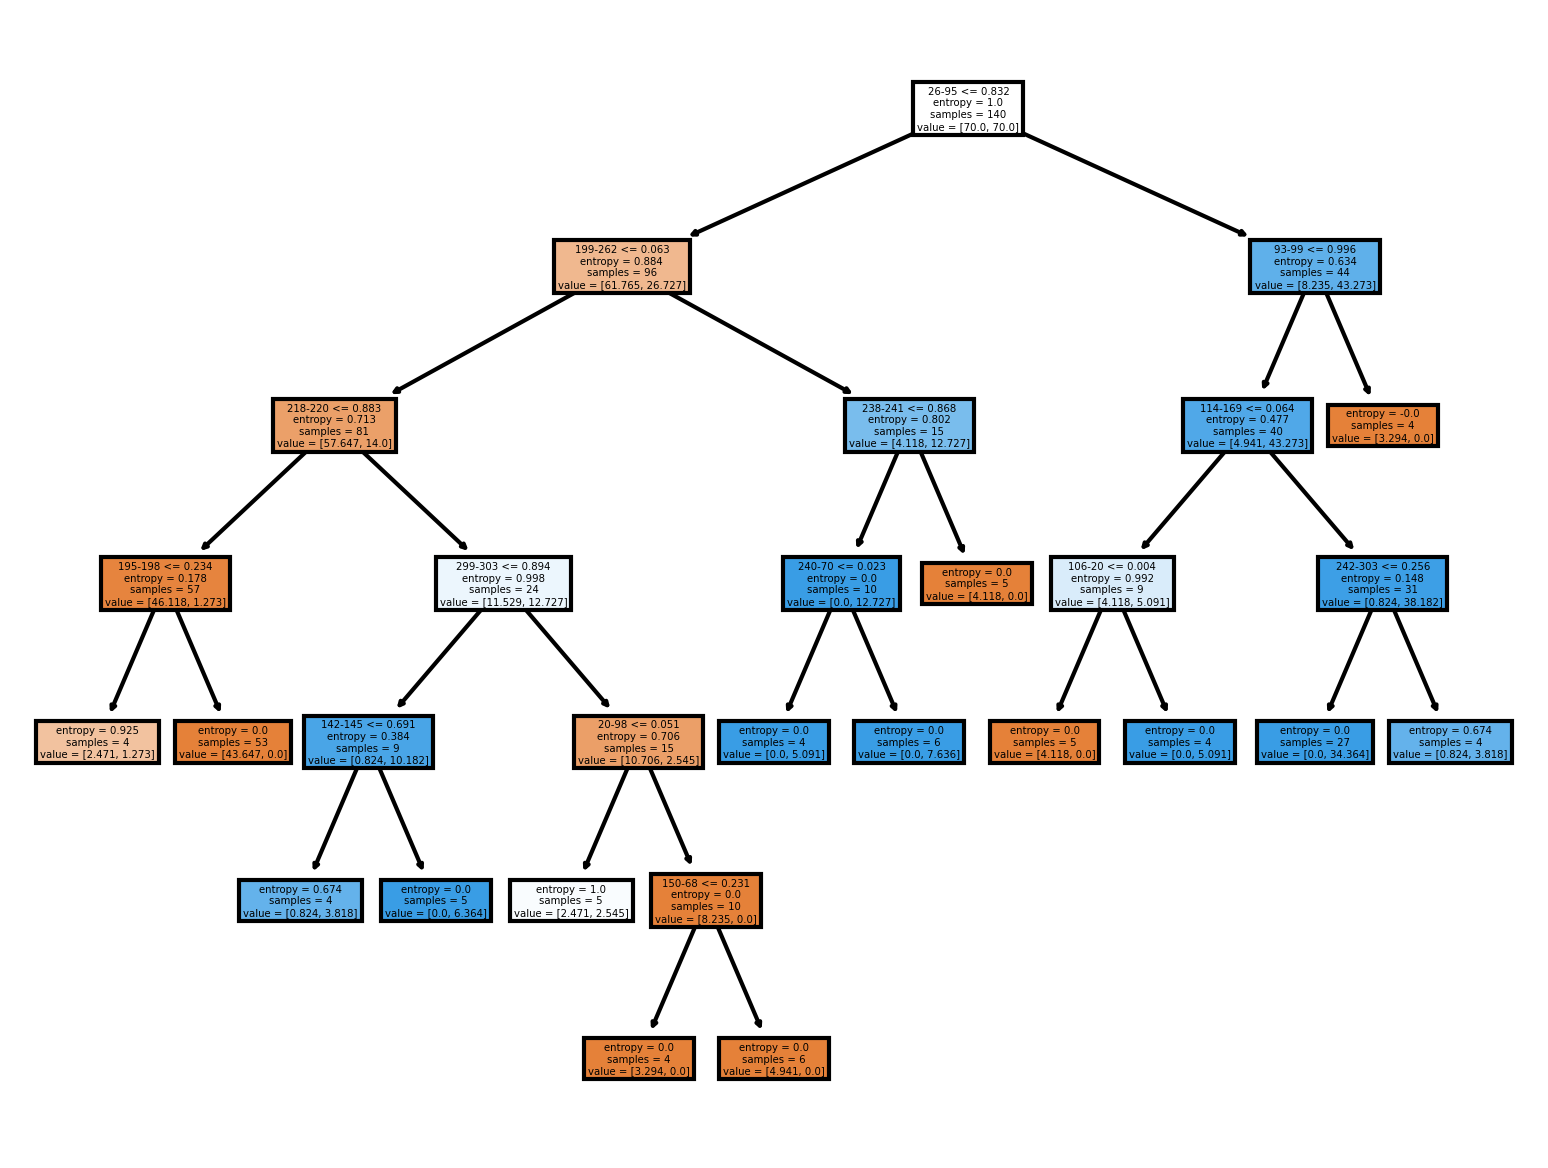

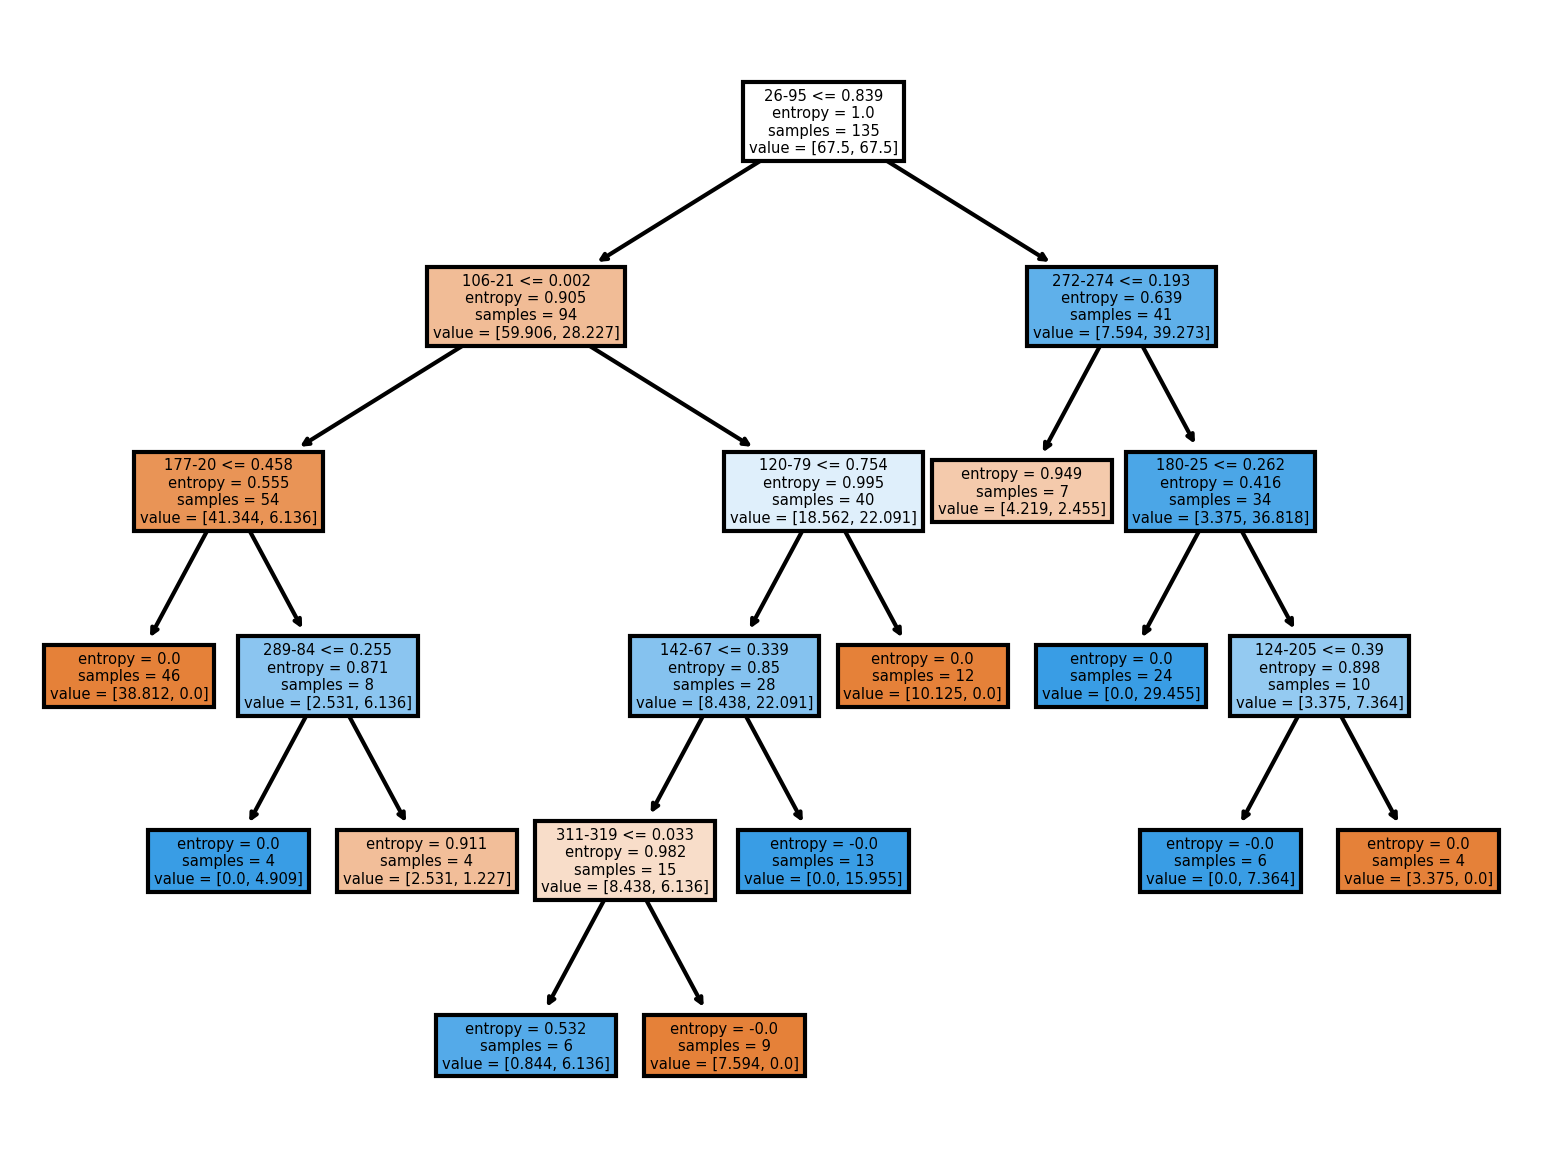

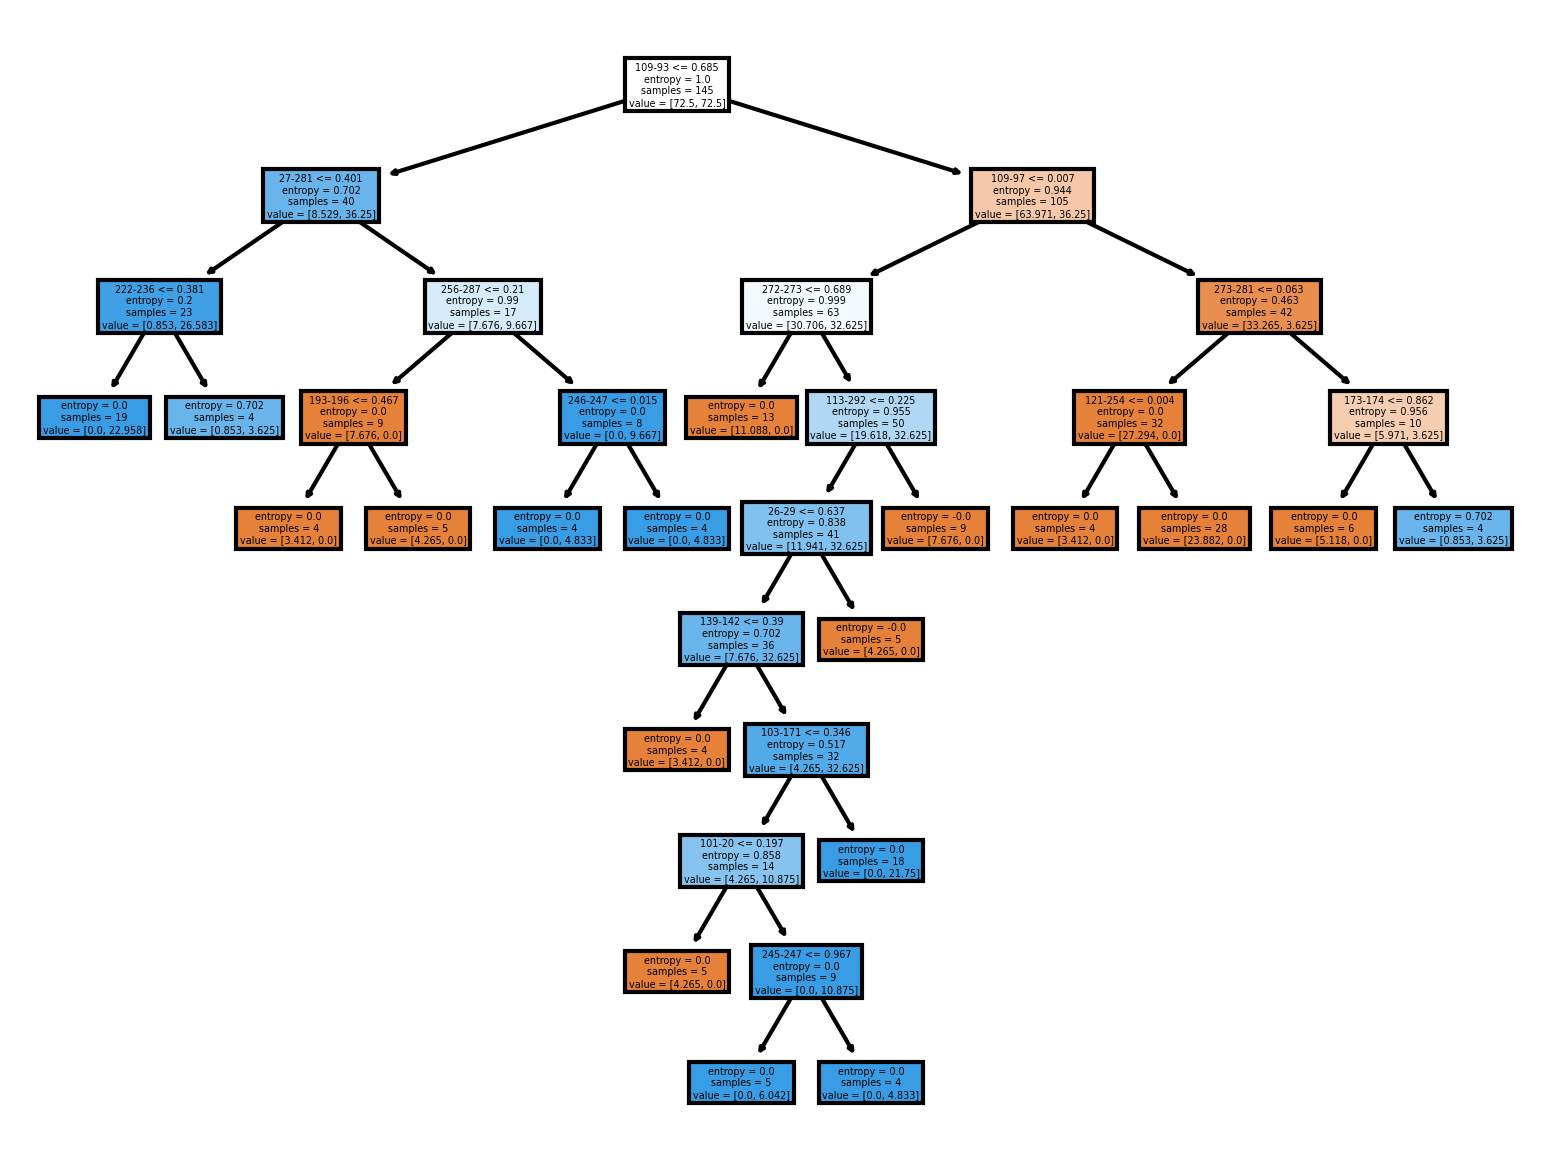

In [95]:
# visualize the best decission tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from glob import glob
import pickle

train_id = grouped_train_df.iloc[1].train_id

model_paths = glob(f"models/*/models/{train_id}/*.pkl")

for model_path in model_paths:

    model = pickle.load(open(model_path, "rb"))

    # get the dataset name from the config file
    config_path = glob(f"models/*/configs/{train_id}.yaml")[0]
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    dataset_path = config["data"]["path"]

    # load the column names of the dataset
    X = pd.read_csv(dataset_path)
    X = X.drop(columns=["position", "profile"]) 

    freature_names = X.columns.to_list()

    # fig, ax = plt.subplots(figsize=(20, 20))
    plt.figure(dpi=300)
    plot_tree(model, feature_names=freature_names, filled=True)
    plt.show()


In [100]:
# get feature importance from all the folds of the second best model
importances = []
for fold in glob(f"models/*/models/{train_id}/*.pkl"):
    model = pickle.load(open(fold, "rb"))
    importances.append(model.feature_importances_)

importances = pd.DataFrame(importances, columns=freature_names)
importances = importances.transpose()
importances = importances.mean(axis=1)
importances = importances.sort_values(ascending=False)


In [107]:
importances.head(50)

26-95      0.107511
109-93     0.076314
177-20     0.030965
218-220    0.029364
139-142    0.029344
30-95      0.028476
311-319    0.026730
58-64      0.025017
256-287    0.024768
258-291    0.024552
120-79     0.023811
222-235    0.023064
121-205    0.022627
199-262    0.021765
238-241    0.021580
106-21     0.021283
109-97     0.020519
285-87     0.020233
272-273    0.019331
142-67     0.019177
179-271    0.019151
101-20     0.018724
113-292    0.018042
299-303    0.016985
258-259    0.016616
38-41      0.016223
147-66     0.015975
124-205    0.015871
84-86      0.015492
93-99      0.015437
106-20     0.014584
22-26      0.013973
26-29      0.013061
114-169    0.012927
27-281     0.012682
285-91     0.012434
180-25     0.011647
48-85      0.011457
273-281    0.011419
272-274    0.011356
106-19     0.010749
133-136    0.009296
103-171    0.008754
173-174    0.008698
195-198    0.007969
20-98      0.006926
289-84     0.006792
203-204    0.005962
242-302    0.004878
117-261    0.004440


/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


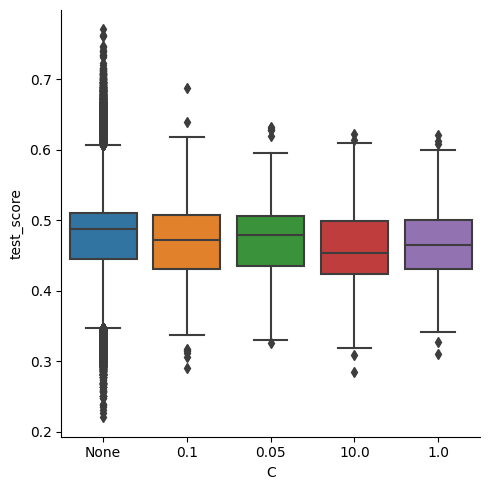

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


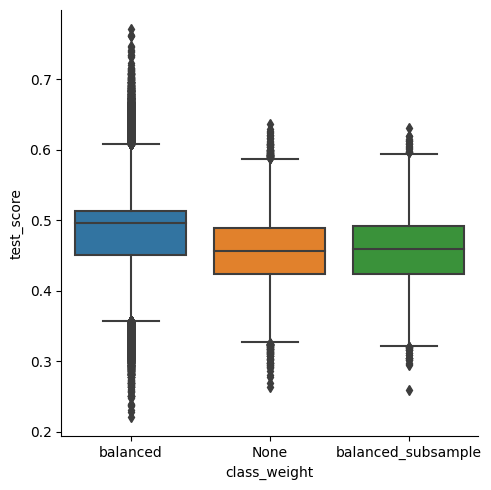

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


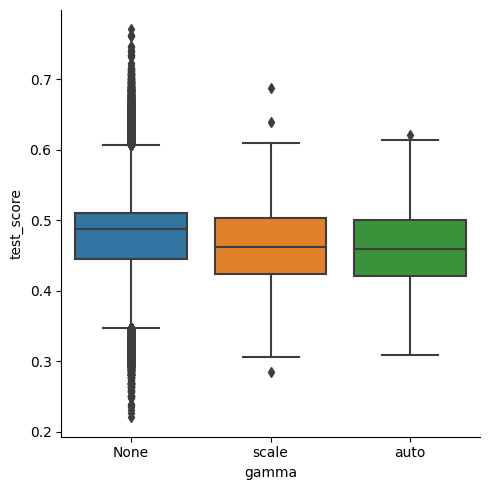

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


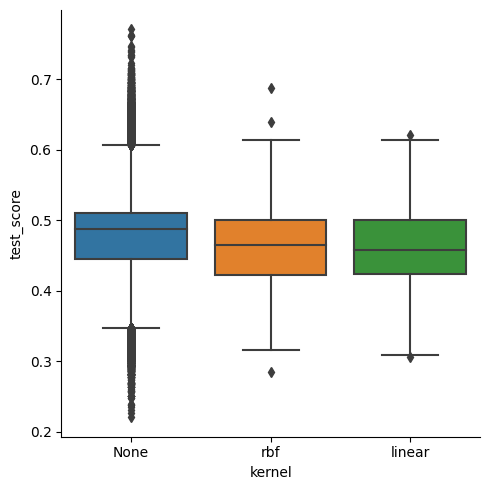

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


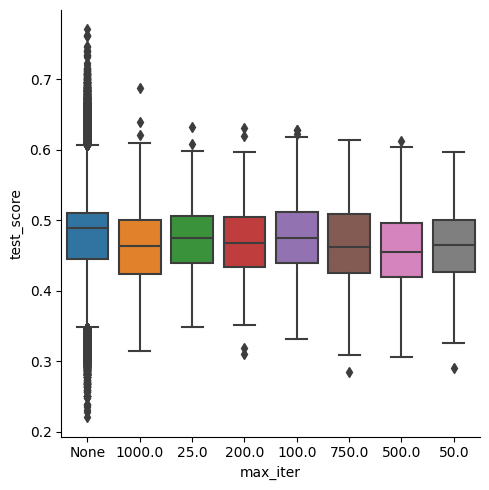

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


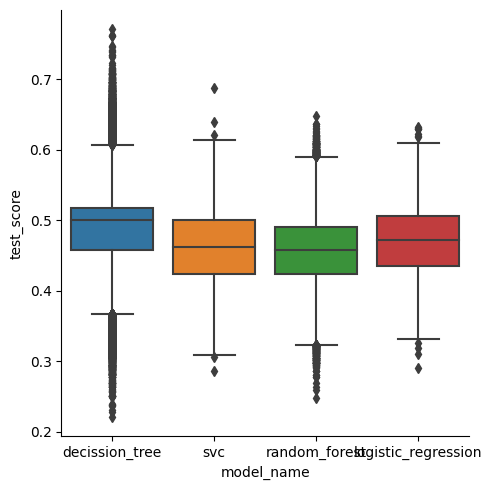

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


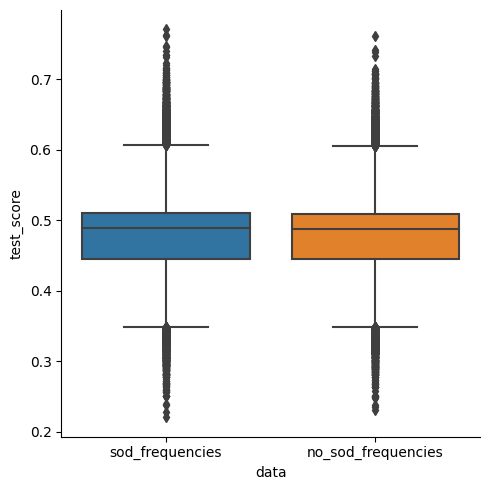

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


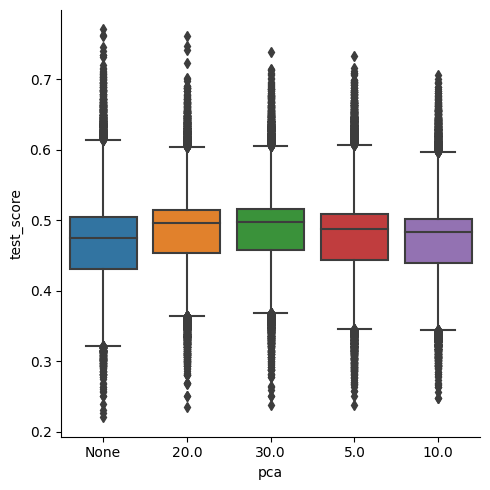

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


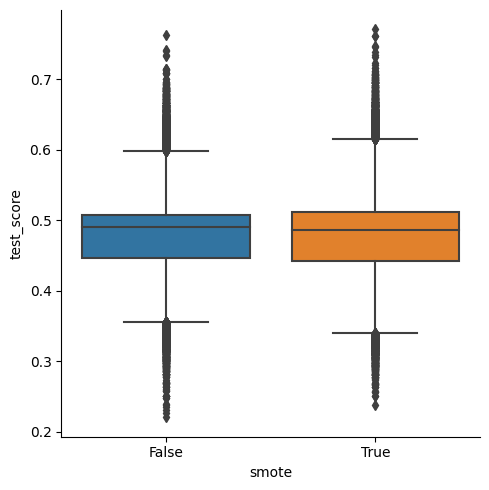

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


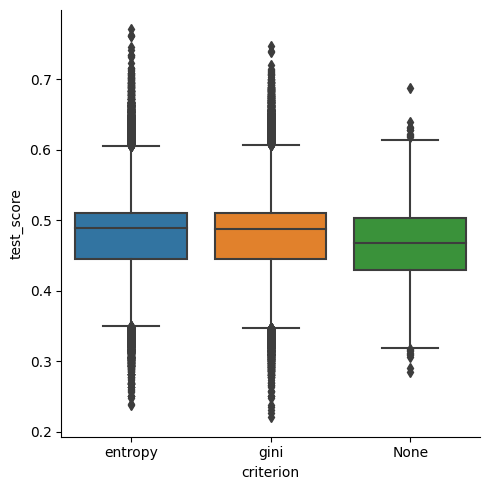

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


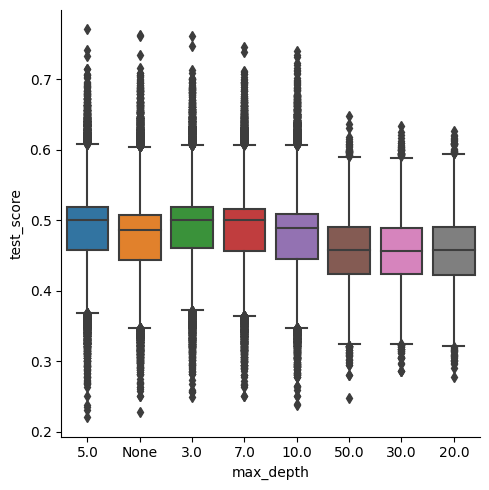

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


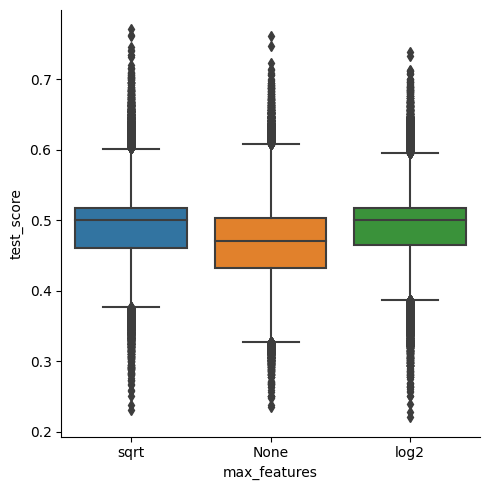

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


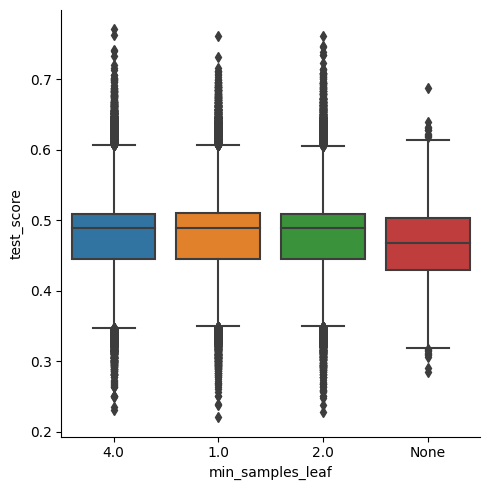

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


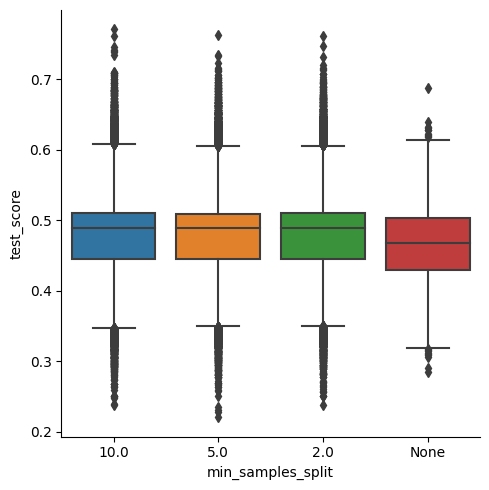

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


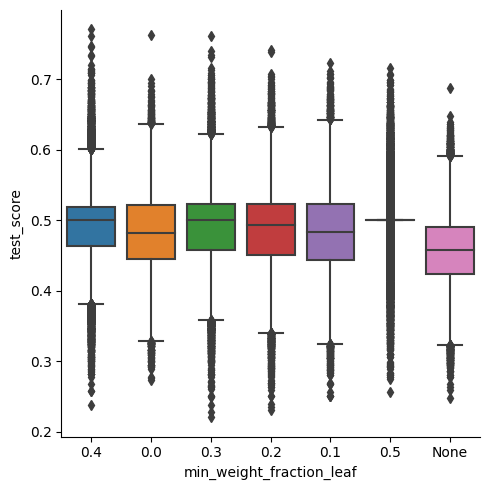

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


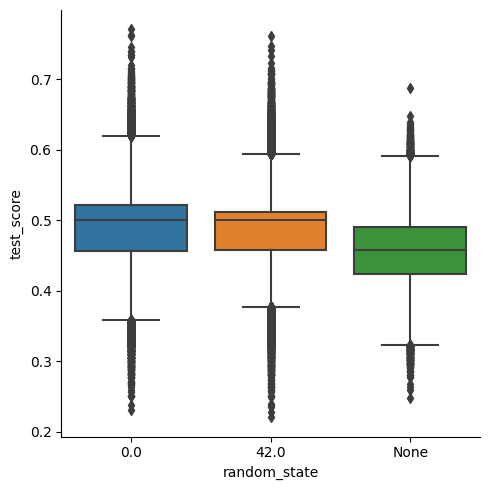

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


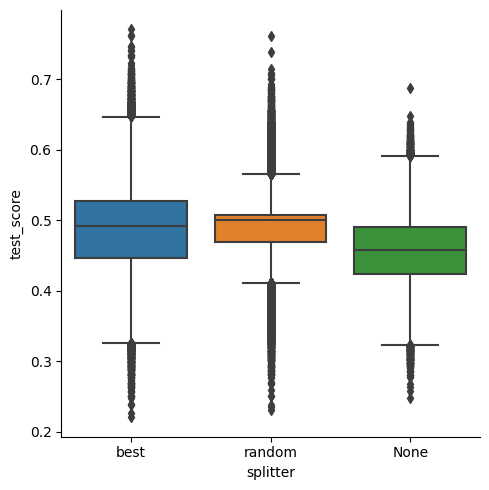

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


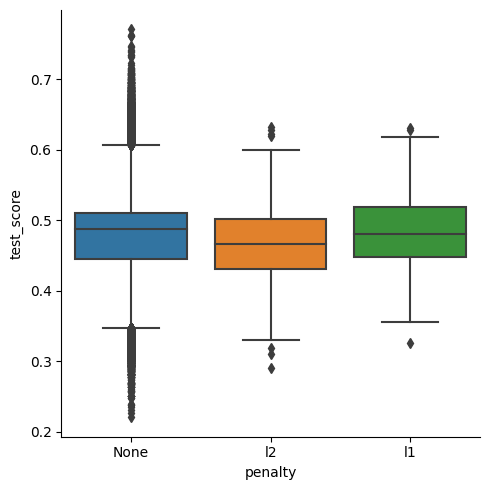

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


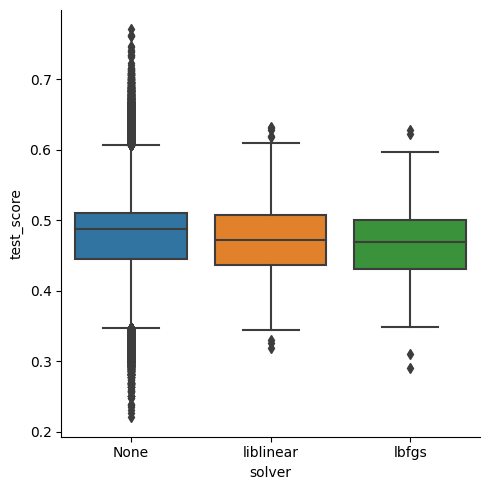

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


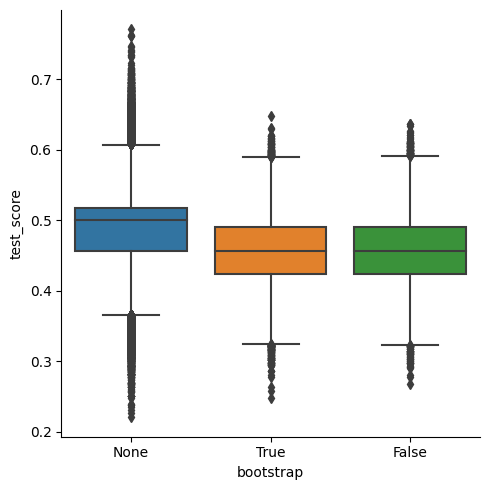

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


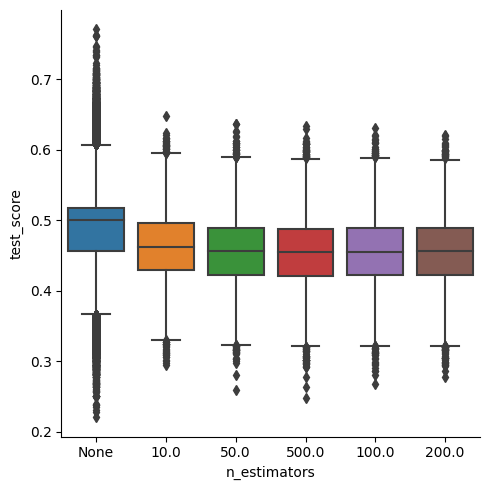

In [48]:
# plot relationship between parameters and test score
for col in cols_to_group:
    if col == "train_id":
        continue
    sns.catplot(x=col, y="test_score", data=train_df, kind="box")
    plt.show()